# Data 620 - Project 3 | Building the best name gender classification

**Group Members: Abdellah Ait Elmouden, Habib Khan, Priya Shaji, Vijaya Cherukuri**

[Video Presentation](https://www.youtube.com/watch?v=e4M-gmKIR2g) 

Using any of the three classifiers described in Chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can.

Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. 

How does the performance on the test set compare to the performacne on the dev-test set? Is this what you'd expect?



In [105]:
# loading libraries
import nltk
from nltk.corpus import names
from nltk.classify import apply_features
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import random
import numpy
import itertools
import re # Regular expression
import textstat

import matplotlib.pyplot as plt

# download names
nltk.download('names')

# set display digits
display_digits=4

[nltk_data] Downloading package names to /home/taha/nltk_data...
[nltk_data]   Package names is already up-to-date!


# Getting the Corpus

In [63]:
# Getting the data and shuffling them
names = ([(name, 'male') for name in names.words('male.txt')] + 
[(name, 'female') for name in names.words('female.txt')])


In [64]:
# Reshuffle the corpus
random.shuffle(names)

In [65]:
# Random names with gender
names[1:15]

[('Ambrosius', 'male'),
 ('Glad', 'female'),
 ('Ulla', 'female'),
 ('Monica', 'female'),
 ('Carlina', 'female'),
 ('Ranna', 'female'),
 ('Kelcy', 'female'),
 ('Milissent', 'female'),
 ('Dinnie', 'female'),
 ('Yehudi', 'male'),
 ('Larry', 'male'),
 ('Gianna', 'female'),
 ('Nero', 'male'),
 ('Maria', 'female')]

In [66]:
# checking the length
len(names)

7944

## Splitting the Data

In order to develop out model, we need to split our data into three different subsets to be used for different purposes. There are 7944 names in the entire dataset. 7444 of the entries will be used for development purposes (6900 for training and 500 for testing) and remaining 500 will be used for testing of a final model.

![alt text](img1.png)


**Development set:**

- 6900 names for the training (train_names)
- 500 names for the testing (devtest_names)

**Test set:**

- 500 names for the testing (test_names)

The training set is used to train the model, and the dev-test set is used to perform error analysis. The test set serves in our final evaluation of the system. For reasons discussed below, it is important that we employ a separate dev-test set for error analysis, rather than just using the test set. 


In [67]:
test_names, devtest_names, train_names = names[0:500], names[500:1000], names[1000:]

In [68]:
# Confirm the size of the three subsets
print("Training Set = {}".format(len(train_names)))
print("Dev-Test Set = {}".format(len(devtest_names)))
print("Test Set = {}".format(len(test_names)))

Training Set = 6944
Dev-Test Set = 500
Test Set = 500


### Data Exploration

In order to determine if there are obvious indicators of gender, we explore some features of the names. We can see the distribution of females and males in our training set as follows:

In [69]:
train_set_gold = [g  for (n, g) in train_names]
nltk.FreqDist(train_set_gold)

FreqDist({'female': 4396, 'male': 2548})

#### First Letter as Indicator

In [70]:
# firstletter
cfd_firstletter = nltk.ConditionalFreqDist(                       #count the frequency of words 
    (gender, name[0].lower()) for name, gender in train_names)


In [72]:
# Normalize for male and female data
fem_count = float(len([gender for name, gender in train_names if gender == 'female']))
male_count = float(len([gender for name, gender in train_names if gender == 'male']))

for i in cfd_firstletter.items():
    if i[0] == 'male':
        for key in i[1].keys():
            i[1][key] = i[1][key]/male_count
    else:
        for key in i[1].keys():
            i[1][key] = i[1][key]/fem_count

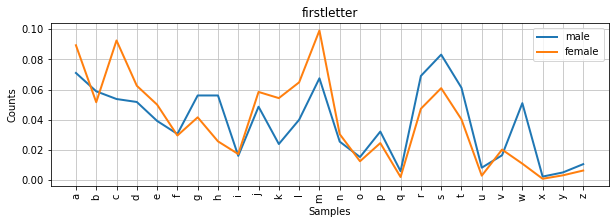

In [73]:
# define title
titleName='firstletter'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_firstletter.plot()

One of the good indicator of gender would be the first letter. The above plot shows the frequency of first letters in regards to gender. From the plot, we can observe that more female names begin with 'a', 'c', and 'm'

#### Last Letter as Indicator

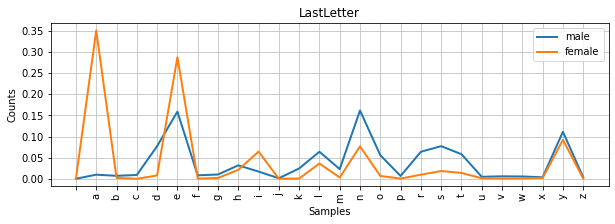

In [34]:
# lastletter
cfd_lastletter = nltk.ConditionalFreqDist(
    (gender, name[-1].lower()) for name, gender in train_names)

for i in cfd_lastletter.items():
    if i[0] == 'male':
        for key in i[1].keys():
            i[1][key] = i[1][key]/male_count
    else:
        for key in i[1].keys():
            i[1][key] = i[1][key]/fem_count

            
# define title
titleName='LastLetter'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_lastletter.plot()

Names ending with letters 'a' and 'e' appear to be a good indicator of a female.

#### First 2 letters

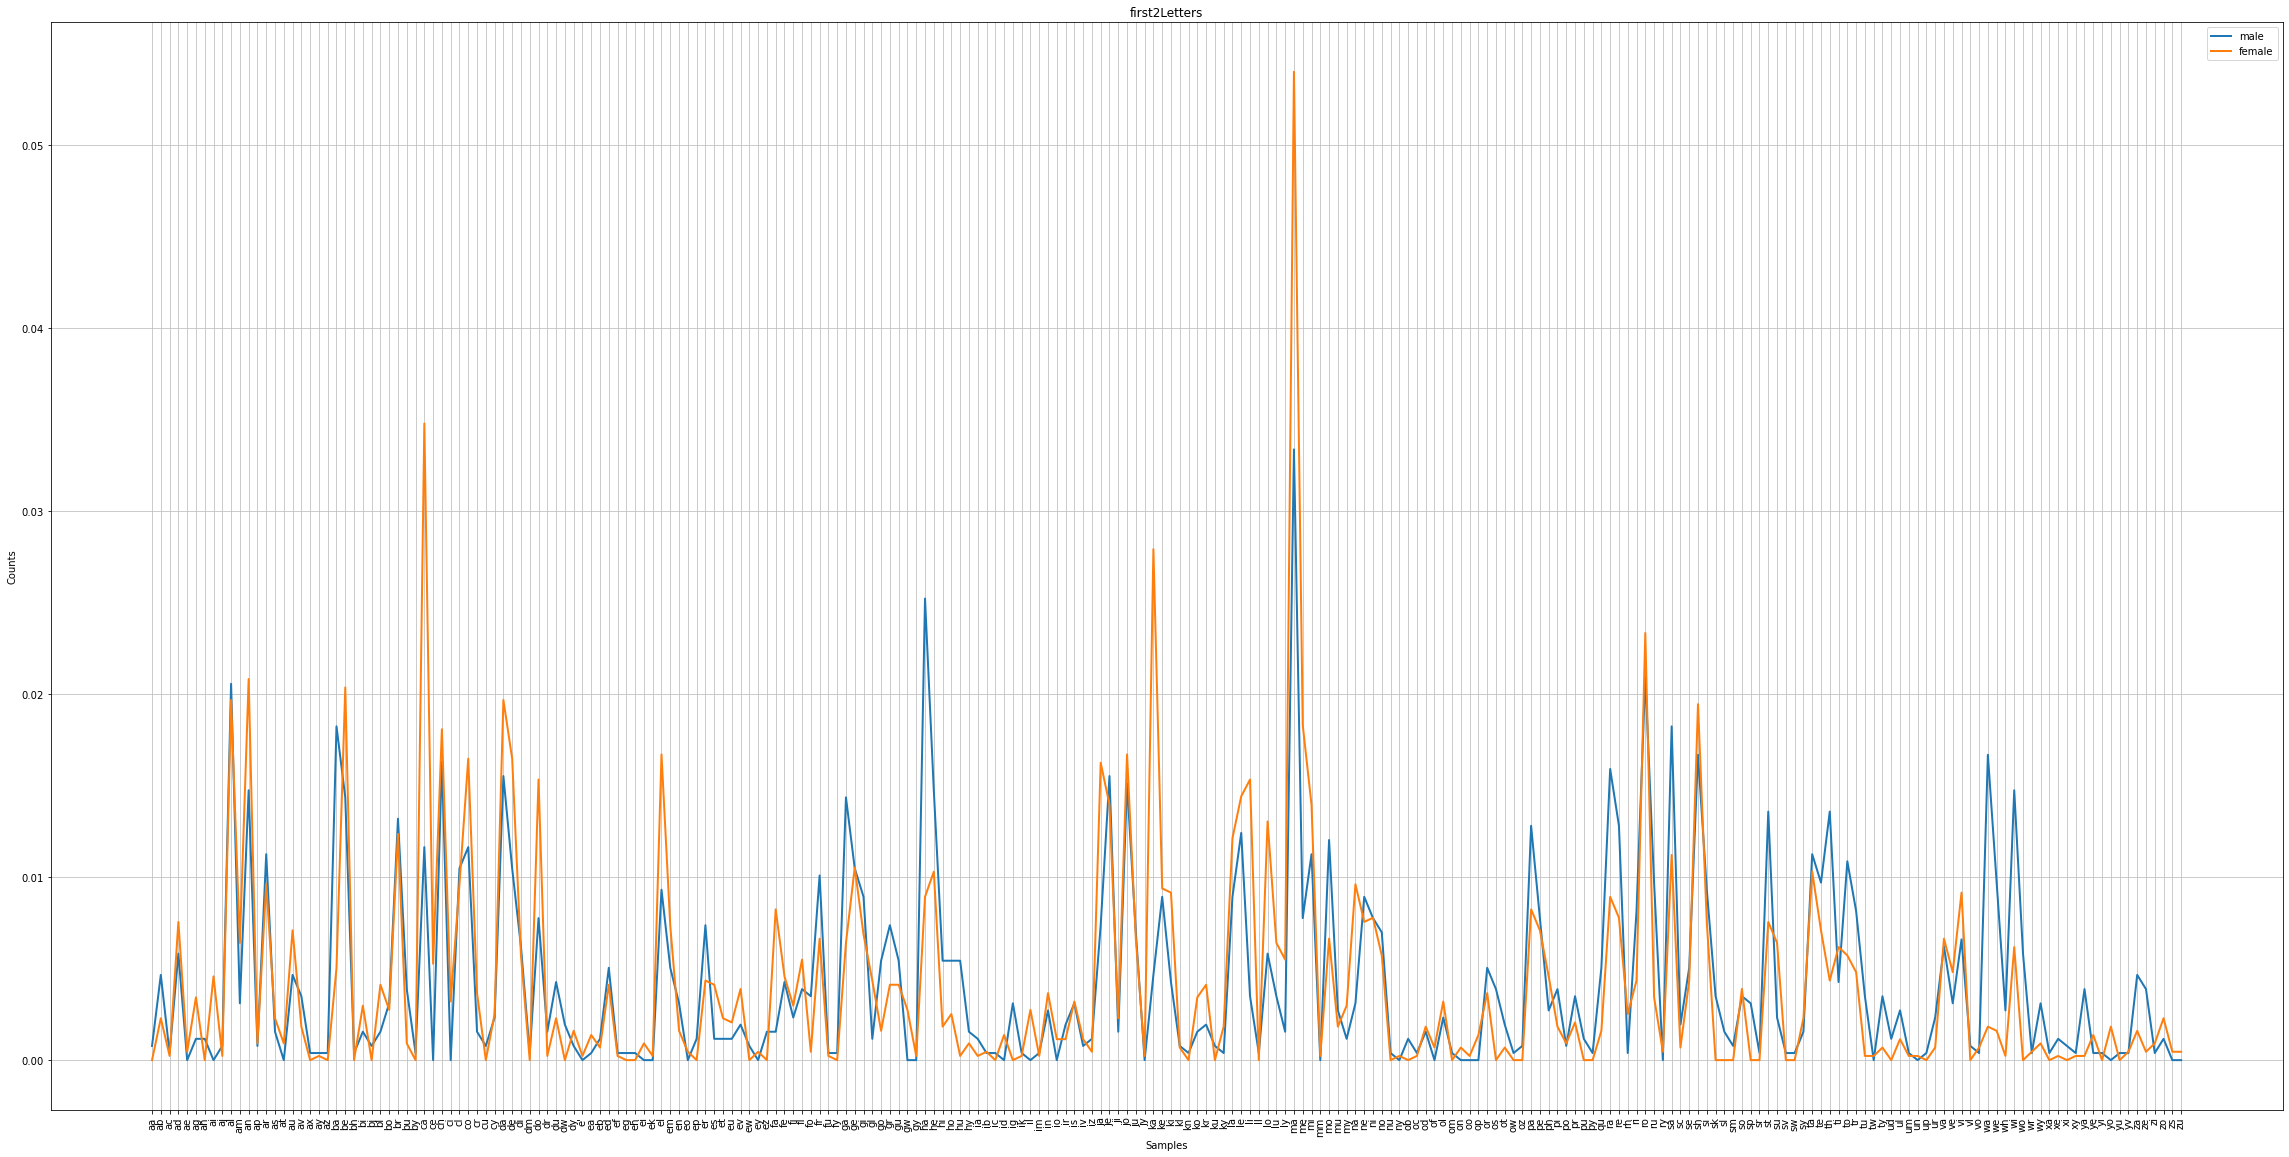

In [41]:
# first2Letters
cfd_first2Letters = nltk.ConditionalFreqDist(
    (gender, name[:2].lower()) for name, gender in train_names)

for i in cfd_first2Letters.items():
    if i[0] == 'male':
        for key in i[1].keys():
            i[1][key] = i[1][key]/male_count
    else:
        for key in i[1].keys():
            i[1][key] = i[1][key]/fem_count

# define title
titleName='first2Letters'

# set figure size
plt.figure(figsize=(40,20))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_first2Letters.plot()

There seems to be some deviation in the last two letters between male and female, We will explore this feature further as it is hard to decipher from the output.

#### Length as an Indicator 

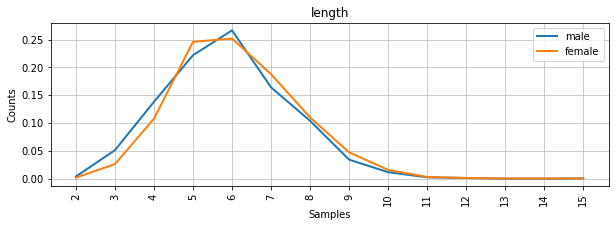

In [36]:
# length
cfd_length = nltk.ConditionalFreqDist(
    (gender, len(name)) for name, gender in train_names)

for i in cfd_length.items():
    if i[0] == 'male':
        for key in i[1].keys():
            i[1][key] = i[1][key]/male_count
    else:
        for key in i[1].keys():
            i[1][key] = i[1][key]/fem_count

# define title
titleName='length'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_length.plot()

The length does not appear to be a great indicator of gender on its own.

#### Vowel Counts Indicator

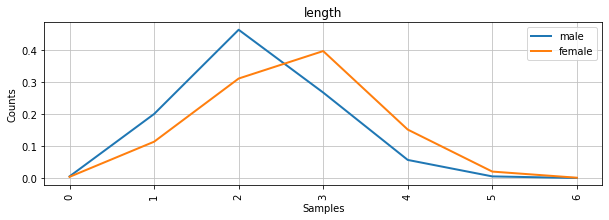

In [39]:
# Vowel Counts
cfd_vowels = nltk.ConditionalFreqDist(
    (gender, len(re.sub(r'[^aeiou]', '', name.lower()))) for name, gender in train_names)

for i in cfd_vowels.items():
    if i[0] == 'male':
        for key in i[1].keys():
            i[1][key] = i[1][key]/male_count
    else:
        for key in i[1].keys():
            i[1][key] = i[1][key]/fem_count

# define title
titleName='length'

# set figure size
plt.figure(figsize=(10,3))
# add title
plt.title(titleName)
# add conditional frequency distribution
cfd_vowels.plot()

The females tend to have more vowels in their name over men.


The above observations of some features was a good starting point for feature selection, but these features do not appear to be good predictors of gender on their own; we need more advanced tools in order to build a good model. We will build a feature extractor for multiple features and then use some introductory machine learning methods to create a model.


### Feature Extractor Functions 

Typically, feature extractors are built through a process of trial-and-error, guided by
intuitions about what information is relevant to the problem.This section below is to incrementally improve the feature extraction functions which are subsequently applied to the development and test datasets.

![alt text](img2.png)

Based on various example in the literature and analysis above, we will initiate our model building the following features:


- First Letter, most names begining with a vowel are associated with females
- First 2 letters
- Last letter
- Last 2 letters
- Last 3 letters
- Vowels count
- Hard consonants using general rules of c and g
- Soft consonants using general rules of c and g
- Syllable Count of names via textstat
- Name length
- Character count
- Character present

We built an function that will return a single feature or a combination of features based on input feature numbers

In [151]:
def get_features(name):
    features = {}
    features["firstletter"] = name[0].lower() # First Letter
    features['first2Letters'] = name[0:2].lower() # First 2 letters
    features["lastletter"] = name[-1].lower() # last letter
    features["last2letters"] = name[-2:].lower() # last 2 letter
    features["last3letters"] = name[-3:].lower() # last 3 letter
    features['vowel_count'] = len(re.sub(r'[^aeiou]', '', name.lower()))  # Vowels count
    features['hard_consts'] = len(re.findall(r'[cg][^eiy]', name.lower()))/2 # Hard consonants using general rules of c and g
    features['soft_consts'] = len(re.findall(r'[cg][eiy]', name.lower()))/2 # Soft consonants using general rules of c and g
    features['syllable_count'] = textstat.syllable_count(name.lower()) # Syllable Count of names via textstat
    features["length"] = len(name) # Name length
    
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        features["count(%s)" % letter] = name.lower().count(letter) # Character present
        features["has(%s)" % letter] = (letter in name.lower())
    return features

get_features('Mr. Sherlock Holmes')

{'firstletter': 'm',
 'first2Letters': 'mr',
 'lastletter': 's',
 'last2letters': 'es',
 'last3letters': 'mes',
 'vowel_count': 4,
 'hard_consts': 0.5,
 'soft_consts': 0.0,
 'syllable_count': 4,
 'length': 19,
 'count(a)': 0,
 'has(a)': False,
 'count(b)': 0,
 'has(b)': False,
 'count(c)': 1,
 'has(c)': True,
 'count(d)': 0,
 'has(d)': False,
 'count(e)': 2,
 'has(e)': True,
 'count(f)': 0,
 'has(f)': False,
 'count(g)': 0,
 'has(g)': False,
 'count(h)': 2,
 'has(h)': True,
 'count(i)': 0,
 'has(i)': False,
 'count(j)': 0,
 'has(j)': False,
 'count(k)': 1,
 'has(k)': True,
 'count(l)': 2,
 'has(l)': True,
 'count(m)': 2,
 'has(m)': True,
 'count(n)': 0,
 'has(n)': False,
 'count(o)': 2,
 'has(o)': True,
 'count(p)': 0,
 'has(p)': False,
 'count(q)': 0,
 'has(q)': False,
 'count(r)': 2,
 'has(r)': True,
 'count(s)': 2,
 'has(s)': True,
 'count(t)': 0,
 'has(t)': False,
 'count(u)': 0,
 'has(u)': False,
 'count(v)': 0,
 'has(v)': False,
 'count(w)': 0,
 'has(w)': False,
 'count(x)': 0,
 

In [152]:
# Testing function 
test_f2 = accuracy(100, get_features('Mr. Sherlock Holmes'))
test_f2.describe()

TypeError: object of type 'WordListCorpusReader' has no len()

### Confusion matrix and The Naive Bayes Classifier 

We built a few functions that will facilitate both the analysis and the display of the results:

- Normalize_confusion_matrix: Returns a normalized confusion matrix
- Plot_confusion_matrix: plot a confusion matrix
- Plot_both_confusion_matrix: plot 2 confusion matrix side by side
- Evaluate_naive_bayes_classifier: train a model using naive bayes classifier 

In [120]:
### Functions for analysis
def normalize_confusion_matrix(cm):
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
    # return confusion matrix
    return cm

In [121]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    Plots the confusion matrix. Set `normalize=True` for normalization.
    """
    if normalize:
        cm = normalize_confusion_matrix(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    return

In [122]:
def plot_both_confusion_matrix(cm,label_names):
    # size figure
    plt.figure(figsize=(10,6))
    # add first subplot
    plt.subplot(2, 2, 1)
    # plot confusion matrix
    plot_confusion_matrix(cm,classes=label_names,normalize=False)
    # add second subplot
    plt.subplot(2, 2, 2)
    # plot confusion matrix (normalized)
    plot_confusion_matrix(cm,classes=label_names,normalize=True)
    
    return

In [116]:
def evaluate_naive_bayes_classifier(train_names,devtest_names,test_names):
    # create feature set (train)
    train_set = [(get_features(n), g)  for (n, g) in train_names]
    # create feature set (dev test)
    devtest_set = [(get_features(n), g)  for (n, g) in devtest_names]
    # create test set (dev test)
    test_set = [(get_features(n), g)  for (n, g) in test_names]
    # build classifier
    classifier = nltk.NaiveBayesClassifier.train(train_set) 
    # compute accuracy (train set)
    train_accuracy=nltk.classify.accuracy(classifier, train_set)
    # compute accuracy (development test set)
    devtest_accuracy=nltk.classify.accuracy(classifier, devtest_set)
    # create predicted classes (train)
    train_set_predictions = [classifier.classify(get_features(n))  for (n, g) in train_names]
    # extract actual classes (gold)
    train_set_gold = [g  for (n, g) in train_names]
    # create confusion matrix
    train_cm=confusion_matrix(train_set_gold, train_set_predictions)
    # get unique classes (train)
    train_label_names =  list(set(train_set_gold) | set(train_set_predictions))    
    # create table with precision, recall, f1-score, and support
    train_report=classification_report(train_set_gold, train_set_predictions,
        digits=display_digits)

    # create predicted classes (dev test)
    devtest_set_predictions = [classifier.classify(get_features(n))  for (n, g) in devtest_names]
    # extract actual classes (gold)
    devtest_set_gold = [g  for (n, g) in devtest_names]
    # create confusion matrix (dev test)
    devtest_cm=confusion_matrix(devtest_set_gold, devtest_set_predictions)
    # get unique classes (dev test)
    devtest_label_names =  list(set(devtest_set_gold) | set(devtest_set_predictions))
    # create table with precision, recall, f1-score, and support
    devtest_report=classification_report(devtest_set_gold, devtest_set_predictions,
        digits=display_digits)
    
    return train_accuracy,train_cm,train_label_names,train_report,devtest_accuracy,devtest_cm,devtest_label_names,devtest_report,classifier

In [144]:
def generate_errors(classifier, dataset): 
    
    errors = [] 

    for (name, tag) in dataset:
        guess = classifier.classify(get_features(name)) 
        if guess != tag: 
            errors.append((tag, guess, name))
            
    return errors

In [145]:
def show_errors(errors, n=None):
   
    if n is not None: errors = errors[:n]
            
    for (tag, guess, name) in sorted(errors): 
        print('correct=%-8s guess=%-8s name=%-30s' %(tag, guess, name))

In [146]:
def generate_prediction(classifier, dataset, extractor_function): 
    
    classification = [] 

    for (name, tag) in dataset:
        guess = classifier.classify(extractor_function(name)) 
        classification.append((name,guess))
            
    return classification

Accuracy (Train): 0.8345334101382489
Accuracy (Development Test): 0.824


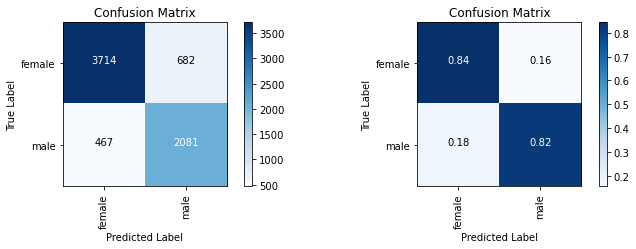

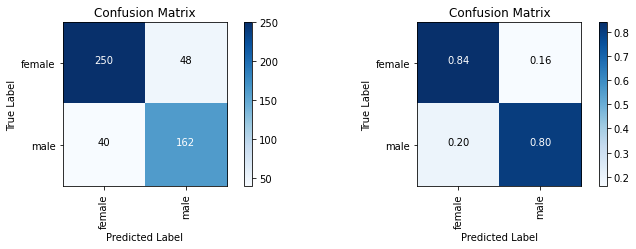

In [131]:
# evaluate the Naive Bayes classifier using gender_features
train_accuracy_nb1,train_cm_nb1,train_label_names_nb1,train_report_nb1, \
    devtest_accuracy_nb1, devtest_cm_nb1,devtest_label_names_nb1, \
    devtest_report_nb1, classifier_nb1=evaluate_naive_bayes_classifier( \
    train_names,devtest_names,test_names)
    
# display model accuracy (train and development test)
print('Accuracy (Train): '+str(train_accuracy_nb1))
print('Accuracy (Development Test): '+str(devtest_accuracy_nb1))
# plot confusion matrix (train)
plot_both_confusion_matrix(train_cm_nb1,['female','male'])
# plot confusion matrix (dev test)
plot_both_confusion_matrix(devtest_cm_nb1,['female','male'])

In [147]:
# display performance report (train)
print('Model Performance Metrics (Train):')
print(train_report_nb1)
# display performance report (dev test)
print('Model Performance Metrics (Development Test):')
print(devtest_report_nb1)

Model Performance Metrics (Train):
              precision    recall  f1-score   support

      female     0.8883    0.8449    0.8660      4396
        male     0.7532    0.8167    0.7837      2548

    accuracy                         0.8345      6944
   macro avg     0.8207    0.8308    0.8248      6944
weighted avg     0.8387    0.8345    0.8358      6944

Model Performance Metrics (Development Test):
              precision    recall  f1-score   support

      female     0.8621    0.8389    0.8503       298
        male     0.7714    0.8020    0.7864       202

    accuracy                         0.8240       500
   macro avg     0.8167    0.8205    0.8184       500
weighted avg     0.8255    0.8240    0.8245       500



In [142]:
# set number of informative features to display
n_informative_features=20
# examine likelihood ratios
classifier_nb1.show_most_informative_features(n_informative_features)

Most Informative Features
            last2letters = 'na'           female : male   =     93.4 : 1.0
            last2letters = 'la'           female : male   =     70.0 : 1.0
            last2letters = 'ia'           female : male   =     50.5 : 1.0
            last2letters = 'us'             male : female =     37.5 : 1.0
            last2letters = 'sa'           female : male   =     32.9 : 1.0
              lastletter = 'a'            female : male   =     32.9 : 1.0
            last2letters = 'rt'             male : female =     30.8 : 1.0
            last2letters = 'ta'           female : male   =     29.5 : 1.0
              lastletter = 'k'              male : female =     29.3 : 1.0
            last2letters = 'do'             male : female =     25.3 : 1.0
            last2letters = 'ra'           female : male   =     24.8 : 1.0
            last3letters = 'ana'          female : male   =     23.5 : 1.0
            last2letters = 'rd'             male : female =     23.5 : 1.0

In [148]:
# Show error 
show_errors(generate_errors(classifier_nb1, devtest_names))

correct=female   guess=male     name=Allison                       
correct=female   guess=male     name=Alyson                        
correct=female   guess=male     name=Aurel                         
correct=female   guess=male     name=Bill                          
correct=female   guess=male     name=Bren                          
correct=female   guess=male     name=Caron                         
correct=female   guess=male     name=Charis                        
correct=female   guess=male     name=Charlot                       
correct=female   guess=male     name=Cody                          
correct=female   guess=male     name=Con                           
correct=female   guess=male     name=Correy                        
correct=female   guess=male     name=Esme                          
correct=female   guess=male     name=Ethel                         
correct=female   guess=male     name=Flory                         
correct=female   guess=male     name=Gretel     

last2letter and lastletter does lead to good results (~83% accuracy on test) as is indicated by the analysis above.

--------------------------------------------------------------------------------------------------------------------

# Analysis

For this project, we will start working on the functions taken from Chapter 6 to test the accuracy of gender classification based on names. There are 2 functions which will be tested first and then finally modified function will be created that will be tested on test data to see final results. 

Before going forward, first we will create an accuracy function that will calculate the accuracy of each function to see which model performed better in terms of gender name classification.

In [13]:
# Defining accuracy function - 

def accuracy(runs, function):
    accuracy_df = {
        "classifier": [],
        "train_accuracy": [],
        "test_accuracy": [],
        "devtest_accuracy": [],
        "devtest_errors": []
    }
    for i in range(runs):
        random.shuffle(names)
        accuracy_train = names[1000:]
        accuracy_devtest = names[500:1000]
        accuracy_test = names[:500]
        
        accuracy_trainset = [(function(n), g) for (n,g) in accuracy_train]
        accuracy_devtestset = [(function(n), g) for (n,g) in accuracy_devtest]
        accuracy_testset = [(function(n), g) for (n,g) in accuracy_test]
        
        accuracy_classifier = nltk.NaiveBayesClassifier.train(accuracy_trainset)
        accuracy_df["classifier"].append(accuracy_classifier)
        accuracy_df["train_accuracy"].append(nltk.classify.accuracy(accuracy_classifier, accuracy_trainset))
        accuracy_df["test_accuracy"].append(nltk.classify.accuracy(accuracy_classifier, accuracy_testset))
        accuracy_df["devtest_accuracy"].append(nltk.classify.accuracy(accuracy_classifier, accuracy_devtestset))
        
        accuracy_errors = []
        for (name, tag) in accuracy_devtest:
            accuracy_guess = accuracy_classifier.classify(function(name))
            if accuracy_guess != tag:
                accuracy_errors.append( (tag, accuracy_guess, name) )
                
        accuracy_df["devtest_errors"].append(accuracy_errors)
        
    accuracy_df = pd.DataFrame.from_dict(accuracy_df)
    return(accuracy_df)

In [14]:
# Creating function 1
def gender_feature1(name):
    return {'last_letter': name[-1]}

gender_feature1("Mr. Sherlock Holmes")

{'last_letter': 's'}

In [15]:
# Creating function 2 - changing into lower
def gender_features2(name):
    features={}
    features["firstletter"]= name[0].lower()
    features["lastletter"] = name[-1].lower()
    features["suffix2"] =  name[-2:].lower()
    features["preffix2"] = name[:2].lower()
    for letter in 'aeiou':
        features["count(%s)" % letter] = name.lower().count(letter)
        features["has(%s)" % letter] = (letter in name.lower())
    return features
gender_features2("Mr. Sherlock Holmes")

{'firstletter': 'm',
 'lastletter': 's',
 'suffix2': 'es',
 'preffix2': 'mr',
 'count(a)': 0,
 'has(a)': False,
 'count(e)': 2,
 'has(e)': True,
 'count(i)': 0,
 'has(i)': False,
 'count(o)': 2,
 'has(o)': True,
 'count(u)': 0,
 'has(u)': False}

In [16]:
# Creating function 3 - 

def gender_features3(name):
    features={}
    features["firstletter"]= name[0].lower()
    features["lastletter"] = name[-1].lower()
    
    # adding parameters if length of name is more than 4 for suffix and preffix
    features["suffix2"] =  name[-3:].lower() if len(name) > 4 else name[-2:].lower()
    features["preffix2"] = name[:3].lower() if len(name) > 4 else name[:2].lower()
    for letter in 'aeiou':
        features["count(%s)" % letter] = name.lower().count(letter)
        features["has(%s)" % letter] = (letter in name.lower())
    return features

In [17]:
gender_features3("Sherlock")

{'firstletter': 's',
 'lastletter': 'k',
 'suffix2': 'ock',
 'preffix2': 'she',
 'count(a)': 0,
 'has(a)': False,
 'count(e)': 1,
 'has(e)': True,
 'count(i)': 0,
 'has(i)': False,
 'count(o)': 1,
 'has(o)': True,
 'count(u)': 0,
 'has(u)': False}

In [149]:
# Testing function 1
test_f1 = accuracy(100, gender_feature1)
test_f1.describe()

TypeError: object of type 'WordListCorpusReader' has no len()

function 1 has accuracy of 0.756300 on test set which was performed through checking the last letter of the names. According to the text in chapter 6, there are patterns in the last letter of the gender which was initially helpful to identify the genders with 75.36% accuracy on the test dataset. Names ending in a, e and i are likely to be female while names ending in k, o, r, s and t are likely to be male. The accuracy did not change significantly throughout the train, devtest and test datasets.

In [19]:
# Testing function 2
test_f2 = accuracy(100, gender_features2)
test_f2.describe()

,train_accuracy,test_accuracy,devtest_accuracy
count,100.000000,100.000000,100.000000
mean,0.808309,0.797380,0.798600
std,0.001935,0.016841,0.018443
min,0.802419,0.752000,0.734000
25%,0.807280,0.788000,0.790000
50%,0.808324,0.797000,0.799000
75%,0.809404,0.810000,0.812000
max,0.813508,0.838000,0.848000


In function 2, more features were added to improve the accuracy of name gender classifications other than the last letter that was discussed previously. In this function, first letter of first name has also been added to see if there is any trend among the genders. Also, number of vowels has also been seen to identify any pattern for male and female. Function 2 improved the accuracy by almost 4 - 5 % in train, test and devtest datasets overall. There is no significant difference in the accuracies among the train, test and devtest datasets which means prediction was almost 80% times accurate to classify the name gender.

In [20]:
# Testing function 3
test_f3 = accuracy(100, gender_features3)
test_f3.describe()

,train_accuracy,test_accuracy,devtest_accuracy
count,100.000000,100.000000,100.000000
mean,0.870593,0.826560,0.827400
std,0.001710,0.017331,0.015132
min,0.866215,0.786000,0.788000
25%,0.869240,0.815500,0.817500
50%,0.870680,0.829000,0.829000
75%,0.872120,0.838000,0.836500
max,0.874424,0.868000,0.868000


Function 3 was modification of previous functions 2. In this function, we added another criteria for suffix and preffix i.e. if the length of name is more than 4 then the function will look up for first 3 and last 3 letters to see the pattern for gender classification out of names. It tremendously improved the accuracy in train dataset which is 87.07% but the accuracy dropped down to around 82.8% on test and devtest datasets but still it is improved version than the previous functions. 

# How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

The performance was checked on all splitted datasets i.e. train, devtest and test through using manually created function "accuracy" which identified the accuracy of each functions on train data, devtest data and test dataset. The first two functions showed no significant difference in the accuracy of devtest as compared to train and test datasets with the average accuracy of 75% and 80% in the first and second functions respectively as expected. The third function had 87% accuracy on the train but on devtest it dropped to 82% which came almost same on the test dataset. We were expecting consistency on devtest and test dataset which we got. 

# References

- Natural Language Processing with Python - Chapter 6
- [The Naive Bayes Algorithm in Python with Scikit-Learn](https://stackabuse.com/the-naive-bayes-algorithm-in-python-with-scikit-learn/)
- [Confusion Matrix](https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html)
- https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789139495/2/ch02lvl1sec17/training-a-sentiment-classifier-for-movie-reviews
- https://www.nltk.org/book/ch06.html
